In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Download data
ticker = "JWL.BO"  # Adjust the ticker as per the Yahoo Finance listing
start_date = '2022-04-01'
end_date = '2024-03-31'

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
returns = 100 * data['Adj Close'].pct_change().dropna()  # Calculate returns

In [4]:
# Display the first few rows of the data
print(data.head())

                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2022-04-01  44.000000  47.500000  43.799999  46.450001  46.348763   32682
2022-04-04  49.849998  49.849998  46.799999  47.799999  47.695820   23069
2022-04-05  47.950001  49.500000  47.049999  48.950001  48.843315   27367
2022-04-06  48.549999  53.799999  48.549999  53.799999  53.682743  123518
2022-04-07  55.000000  57.400002  49.500000  50.349998  50.240261  136554


In [5]:
# Calculate returns
data['Return'] = 100 * data['Adj Close'].pct_change().dropna()  # Calculate returns
data = data.dropna()  # Drop rows with NaN values resulting from pct_change()

In [6]:
# Check for ARCH effects using the Ljung-Box test on squared returns
lb_test = sm.stats.diagnostic.acorr_ljungbox(data['Return']**2, lags=[10], return_df=True)
print('Ljung-Box test for ARCH effects:')
print(lb_test)

Ljung-Box test for ARCH effects:
      lb_stat     lb_pvalue
10  70.997247  2.844877e-11


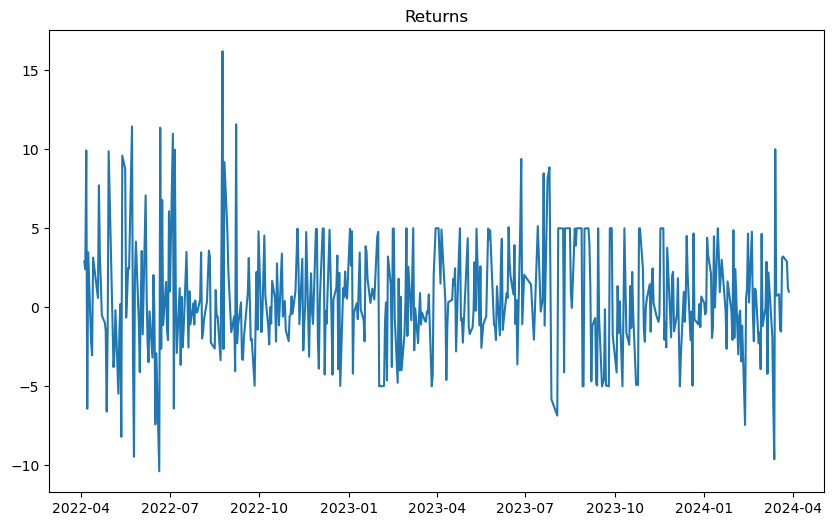

In [7]:
# Check for ARCH/GARCH effects
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.title('Returns')
plt.show()

In [8]:
# Fit an ARCH model
model = arch_model(returns, vol='ARCH', p=2, q=1)
results = model.fit(disp='off')
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1257.01
Distribution:                  Normal   AIC:                           2522.03
Method:            Maximum Likelihood   BIC:                           2538.67
                                        No. Observations:                  474
Date:                Thu, Jul 25 2024   Df Residuals:                      473
Time:                        17:41:54   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.4510      0.145      3.103  1.917e-03 [  0.166,  0.73

In [9]:
# Fit an GARCH model
model = arch_model(returns, vol='GARCH', p=1, q=1)
results = model.fit(disp='off')
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1256.74
Distribution:                  Normal   AIC:                           2521.49
Method:            Maximum Likelihood   BIC:                           2538.13
                                        No. Observations:                  474
Date:                Thu, Jul 25 2024   Df Residuals:                      473
Time:                        17:41:54   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5003      0.140      3.585  3.369e-04 [  0.227,  0.77

In [10]:
# Forecast the three-month volatility
forecast = results.forecast(horizon=90)
volatility_forecast = forecast.variance[-1:]  # Last forecasted variance
volatility_forecast = volatility_forecast.apply(lambda x: x**0.5)  # Convert to standard deviation
print(volatility_forecast)

                h.01      h.02     h.03      h.04     h.05      h.06  \
Date                                                                   
2024-03-28  2.959976  3.033102  3.09727  3.153756  3.20361  3.247706   

                h.07      h.08      h.09      h.10  ...      h.81      h.82  \
Date                                                ...                       
2024-03-28  3.286784  3.321469  3.352296  3.379727  ...  3.611168  3.611179   

                h.83      h.84      h.85      h.86      h.87      h.88  \
Date                                                                     
2024-03-28  3.611189  3.611197  3.611205  3.611212  3.611218  3.611224   

                h.89      h.90  
Date                            
2024-03-28  3.611229  3.611233  

[1 rows x 90 columns]


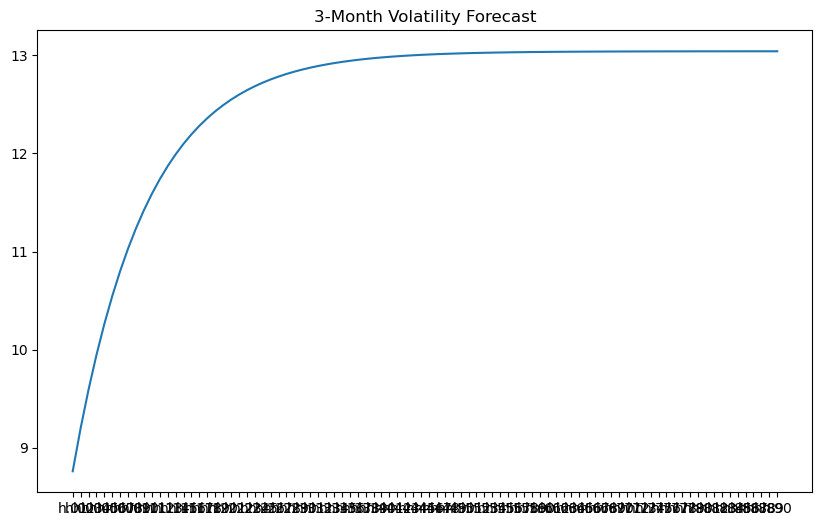

In [11]:
# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(forecast.variance[-1:].T)
plt.title('3-Month Volatility Forecast')
plt.show()

## **Part B**

In [17]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [23]:
# Set working directory
os.getcwd()

'C:\\Users\\Adarsh\\Favorites\\SCMA 2024\\Assignments\\A6b'

In [25]:
# Load the data
df = pd.read_excel('CMO-Historical-Data-Monthly.xlsx', sheet_name="Monthly Prices", skiprows=6)

# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

# Convert the Date column to datetime format
def parse_date(date_str):
    year, month = date_str[:4], date_str[5:7]
    return pd.to_datetime(f'{year}-{month}-01')

df['Date'] = df['Date'].apply(parse_date)

# Display the structure of the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           774 non-null    datetime64[ns]
 1   CRUDE_PETRO    774 non-null    float64       
 2   CRUDE_BRENT    774 non-null    float64       
 3   CRUDE_DUBAI    774 non-null    float64       
 4   CRUDE_WTI      774 non-null    object        
 5   COAL_AUS       774 non-null    object        
 6   COAL_SAFRICA   774 non-null    object        
 7   NGAS_US        774 non-null    float64       
 8   NGAS_EUR       774 non-null    float64       
 9   NGAS_JP        774 non-null    object        
 10  iNATGAS        774 non-null    object        
 11  COCOA          774 non-null    float64       
 12  COFFEE_ARABIC  774 non-null    float64       
 13  COFFEE_ROBUS   774 non-null    float64       
 14  TEA_AVG        774 non-null    float64       
 15  TEA_COLOMBO    774 non-

In [26]:
# Get the column numbers for each column
column_numbers = {col: idx for idx, col in enumerate(df.columns)}

# Select relevant columns
commodity = df.iloc[:, [0, 15, 16, 17, 12, 13]]

# Clean column names
commodity.columns = commodity.columns.str.lower().str.replace(' ', '_')

# Display the structure of the commodity dataframe
print(commodity.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           774 non-null    datetime64[ns]
 1   tea_colombo    774 non-null    float64       
 2   tea_kolkata    774 non-null    float64       
 3   tea_mombasa    774 non-null    float64       
 4   coffee_arabic  774 non-null    float64       
 5   coffee_robus   774 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 36.4 KB
None


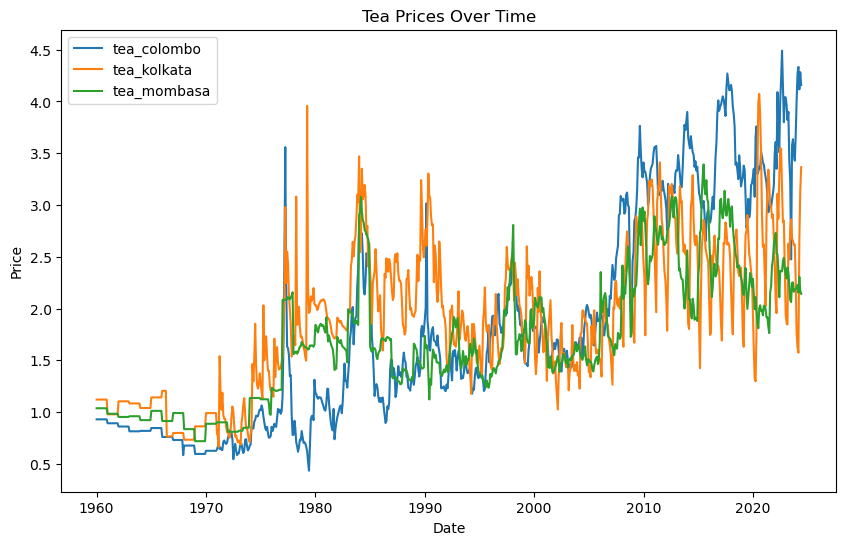

In [29]:
# Plot the data
# Plotting tea prices
plt.figure(figsize=(10, 6))
for col in commodity.columns[1:4]:
    plt.plot(commodity['date'], commodity[col], label=col)

plt.legend()
plt.title('Tea Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

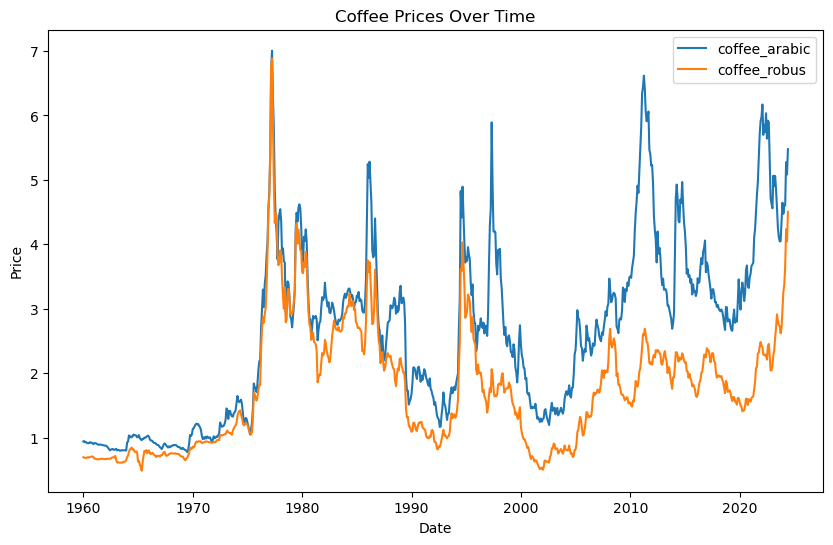

In [31]:
# Plotting coffee prices
plt.figure(figsize=(10, 6))
for col in commodity.columns[4:]:
    plt.plot(commodity['date'], commodity[col], label=col)

plt.legend()
plt.title('Coffee Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [33]:
# Exclude the Date column
commodity_data = commodity.drop(columns=['date'])

In [35]:
# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

# Function to perform the ADF test and extract p-value
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # p-value

# Loop through each column and perform the ADF test
for col in commodity_data.columns:
    p_value = adf_test(commodity_data[col])
    print(f"\nADF test result for column: {col}\n")
    print(f"P-value: {p_value}")
    
    if p_value > 0.05:
        non_stationary_count += 1
        non_stationary_columns.append(col)
    else:
        stationary_columns.append(col)

# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}\n")
print(f"Non-stationary columns: {non_stationary_columns}\n")
print(f"Stationary columns: {stationary_columns}")

# Co-Integration Test (Johansen's Test)
lags = 10  # Setting maximum lags
johansen_test = coint_johansen(commodity_data, det_order=0, k_ar_diff=lags)

# Determining the number of co-integrating relationships (r)
r = sum(johansen_test.lr1 > johansen_test.cvt[:, 1])  # Number of significant eigenvalues


ADF test result for column: tea_colombo

P-value: 0.8278999491817848

ADF test result for column: tea_kolkata

P-value: 0.48882960867443087

ADF test result for column: tea_mombasa

P-value: 0.1964883065294034

ADF test result for column: coffee_arabic

P-value: 0.28931825084727825

ADF test result for column: coffee_robus

P-value: 0.17581389077815474

Number of non-stationary columns: 5

Non-stationary columns: ['tea_colombo', 'tea_kolkata', 'tea_mombasa', 'coffee_arabic', 'coffee_robus']

Stationary columns: []


Det. terms outside the coint. relation & lagged endog. parameters for equation tea_colombo
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0055      0.013     -0.436      0.663      -0.030       0.019
L1.tea_colombo       -0.0770      0.038     -2.027      0.043      -0.151      -0.003
L1.tea_kolkata        0.0350      0.024      1.443      0.149      -0.013       0.082
L1.tea_mombasa        0.0695      0.050      1.399      0.162      -0.028       0.167
L1.coffee_arabic     -0.0192      0.038     -0.507      0.612      -0.093       0.055
L1.coffee_robus       0.2229      0.058      3.851      0.000       0.109       0.336
L2.tea_colombo       -0.1036      0.038     -2.743      0.006      -0.178      -0.030
L2.tea_kolkata        0.0268      0.024      1.119      0.263      -0.020       0.074
L2.tea_mombasa        0.0698      0.049      1.42

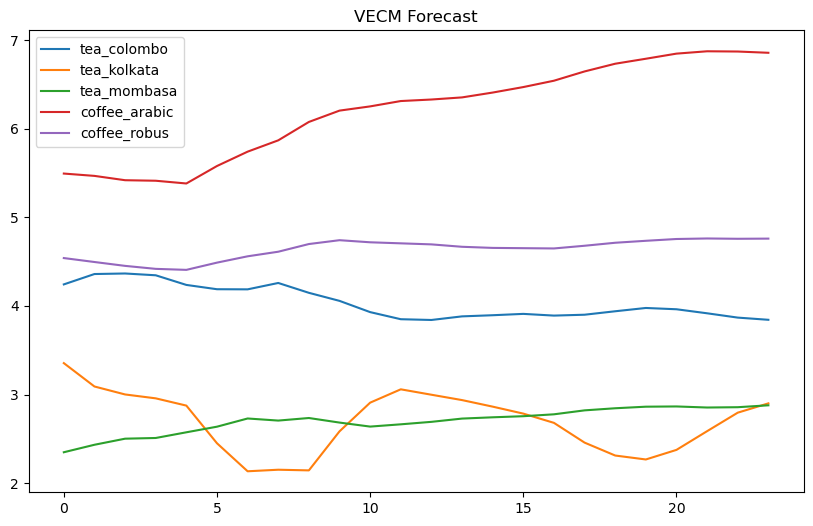

In [37]:
if r > 0:
    # If co-integration exists, estimate the VECM model
    vecm_model = VECM(commodity_data, k_ar_diff=lags, coint_rank=r, deterministic='co').fit()
    
    # Summary of the VECM model
    print(vecm_model.summary())
    
    # Creating a VAR model for prediction using the VECM
    vecm_pred = vecm_model.predict(steps=24)
    
    # Forecasting using the VECM model
    forecast = pd.DataFrame(vecm_pred, columns=commodity_data.columns)
    
    # Plotting the forecast
    forecast.plot(figsize=(10, 6))
    plt.title('VECM Forecast')
    plt.show()

else:
    # If no co-integration exists, proceed with Unrestricted VAR Analysis
    var_model = VAR(commodity_data)
    var_result = var_model.fit(maxlags=lags, ic='aic')
    
    # Summary of the VAR model
    print(var_result.summary())
    
    # Forecasting using the VAR model
    forecast = var_result.forecast(var_result.y, steps=24)
    forecast_df = pd.DataFrame(forecast, columns=commodity_data.columns)
    
    # Plotting the forecast
    forecast_df.plot(figsize=(10, 6))
    plt.title('VAR Forecast')
    plt.show()

In [45]:
forecast

,tea_colombo,tea_kolkata,tea_mombasa,coffee_arabic,coffee_robus
0,4.242843,3.354899,2.349708,5.492988,4.539901
1,4.359808,3.091345,2.434075,5.466696,4.495392
2,4.365895,3.001502,2.502677,5.417897,4.451762
3,4.345644,2.957660,2.510520,5.412008,4.418061
4,4.236897,2.875760,2.574655,5.381068,4.406736
5,4.188370,2.450967,2.637978,5.578172,4.488370
6,4.187045,2.135033,2.730442,5.740043,4.559660
7,4.258934,2.152518,2.706888,5.867679,4.611403
8,4.147914,2.145088,2.735816,6.075152,4.698074
9,4.057051,2.585428,2.684315,6.202951,4.741390
